In [ ]:
#@title # 1. Установка нужных вещей

#@markdown В этой ячейке спрятан код, который клонирует нужный репозиторий и создает папки. 

%tensorflow_version 1.x
from IPython.display import clear_output
%cd /content/
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch/
!git clone https://github.com/justinpinkney/stylegan2/
!pip install ninja

!mkdir raw
!mkdir aligned
!mkdir generated

clear_output()
print('Done!')

Done!


In [ ]:
#@title # 1.1 Загрузим нейросетки, которые генерируют людей и собак отдельно

#@markdown  
%cd /content/
from IPython.display import clear_output
import json

!curl https://raw.githubusercontent.com/dobrosketchkun/wd_network_zoo/main/wd_networks.json -O wd_networks.json


with open('/content/wd_networks.json', 'r') as f:
    jnetw = json.loads(f.read())

nn_list = list(jnetw.keys())

network_name = ['ffhq', 'corgi'] #@#param {type:"string"}
download_all = False #@#param {type:"boolean"}

if download_all:
    for nn in nn_list:
        url = jnetw[nn]
        id =  url.split('/')[-2]
        network_f_name = nn + '.pkl'
        !gdown --id $id -O $network_f_name
    clear_output()
    network_name = 'ffhq'
    print('Network:', network_name)
else:
    if network_name:
        for i in network_name:
            if not i:
                print('List of available networks:')
                print(', '.join(nn_list))
            elif i not in nn_list:
                print('Error, You can not use {}! Only names from this list are available:'.format(network_name))
                print(', '.join(nn_list))
            else:
                clear_output()
                print('Network:', i)
                url = jnetw[i]
                id =  url.split('/')[-2]
                network_f_name = i + '.pkl'
                !gdown --id $id -O $network_f_name

clear_output()

In [ ]:
#@title # 1.2 Немного полезных функций
%cd /content/stylegan2-ada-pytorch/
import os
import re
from typing import List, Optional

import click
import dnnlib
import numpy as np
import PIL.Image
import torch
from io import BytesIO
import legacy
import argparse
import PIL.Image
import re
import sys
import IPython.display

from math import ceil
from PIL import Image, ImageDraw
import imageio
import os
import pickle
from google.colab import files


def load_networks(path):
    stream = open(path, 'rb')    
    with stream:
        G  = pickle.load(stream, encoding='latin1')['G_ema']   
    return G


def generate_images(zs, truncation_psi):

        
    imgs = []
 
    # for seed_idx, seed in enumerate(seeds):
    for z_idx, z in log_progress(enumerate(zs), size = len(zs), name = "Generating images"):
        img = G(z, None, truncation_psi=truncation_psi, noise_mode=noise_mode)
        img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        imgs.append(PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB'))

    return imgs

def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
     
        z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(device)
        zs.append(z)
    return zs

# Generates a list of images, based on a list of seed for latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi)

def saveImgs(imgs, location):
  for idx, img in log_progress(enumerate(imgs), size = len(imgs), name="Saving images"):
    file = location+ str(idx) + ".png"
    img.save(file)

def imshow(a, format='png', jpeg_fallback=True, save=False, id=None):
  a = np.asarray(a, dtype=np.uint8)
  str_file = BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  #####
  if save:
      PIL.Image.fromarray(a).save(str(id[0]) + '.png', format)
  ####
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

        
def clamp(x, minimum, maximum):
    return max(minimum, min(x, maximum))
    
def drawLatent(image,latents,x,y,x2,y2, color=(255,0,0,100)):
  buffer = PIL.Image.new('RGBA', image.size, (0,0,0,0))
   
  draw = ImageDraw.Draw(buffer)
  cy = (y+y2)/2
  draw.rectangle([x,y,x2,y2],fill=(255,255,255,180), outline=(0,0,0,180))
  for i in range(len(latents)):
    mx = x + (x2-x)*(float(i)/len(latents))
    h = (y2-y)*latents[i]*0.1
    h = clamp(h,cy-y2,y2-cy)
    draw.line((mx,cy,mx,cy+h),fill=color)
  return PIL.Image.alpha_composite(image,buffer)
             
  
def createImageGrid(images, scale=0.25, rows=1):
   w,h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = rows*h
   cols = ceil(len(images) / rows)
   width = cols*w
   canvas = PIL.Image.new('RGBA', (width,height), 'white')
   for i,img in enumerate(images):
     img = img.resize((w,h), PIL.Image.ANTIALIAS)
     canvas.paste(img, (w*(i % cols), h*(i // cols))) 
   return canvas

def convertZtoW(latent, truncation_psi=0.7, truncation_cutoff=9):
  dlatent = Gs.components.mapping.run(latent, None) # [seed, layer, component]
  dlatent_avg = Gs.get_var('dlatent_avg') # [component]
  for i in range(truncation_cutoff):
    dlatent[0][i] = (dlatent[0][i]-dlatent_avg)*truncation_psi + dlatent_avg
    
  return dlatent

def interpolate(zs, steps):
   out = []
   for i in range(len(zs)-1):
    for index in range(steps):
     fraction = index/float(steps) 
     out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
   return out

# Taken from https://github.com/alexanderkuk/log-progress
def log_progress(sequence, every=1, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )


def upload_image(name: str) -> str:
    uploaded = files.upload()
    pic_name = list(uploaded.keys())[0]
    img = Image.open(pic_name)
    path = '/content/raw/'
    img.save(path + name)
    return name


def to_pillow(tensor: np.ndarray):
    tensor = tensor.transpose(1, 2, 0)
    tensor = (tensor + 1) / 2
    tensor = np.clip(tensor, 0, 1)
    tensor *= 255
    return Image.fromarray(tensor.astype('uint8'))

/content/stylegan2-ada-pytorch


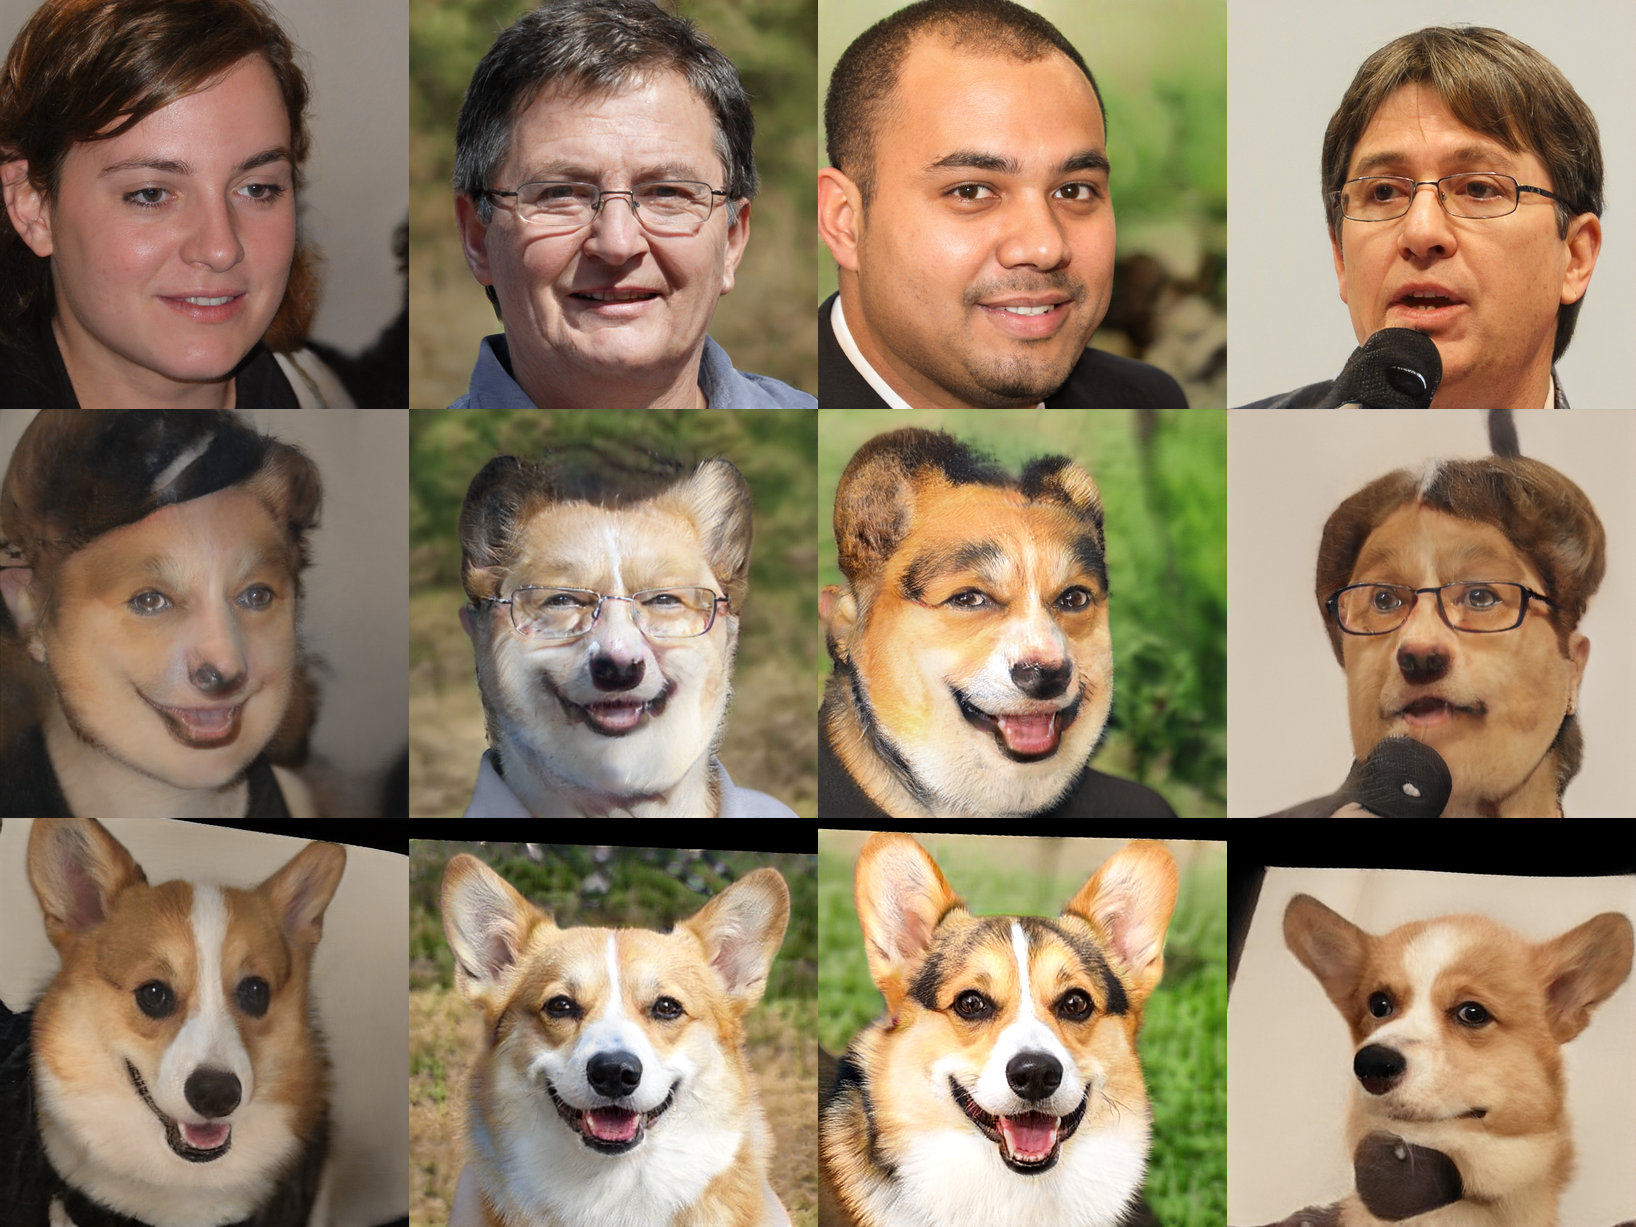

/content
from_face_to_doggo.pkl is saved.
/content/stylegan2


In [ ]:
#@title # 2. Смешивание слоев
%cd /content/stylegan2-ada-pytorch/

from IPython.display import display, clear_output


size = 4

seeds = np.random.randint((2**32 - 1), size=size)

#############################################
 #@markdown начальная нейросеть ffhq, она генерирует лица
network_name1 = 'ffhq'
 #@markdown слои берем из нейросети, которая генерирует собак

network_name2 = 'corgi'

noise_mode = 'const'
device = torch.device('cuda')
############################



network_pkl0 = '/content/' + network_name2.strip() + '.pkl'

with dnnlib.util.open_url(network_pkl0) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

imgs0 = generate_images_from_seeds(seeds, 0.7)

#########################


network_pkl1 = '/content/' + network_name1.strip() + '.pkl'

network_pkl = '/content/stylegan2-ffhq-config-f.pkl'
with dnnlib.util.open_url(network_pkl1) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore


network_pkl2 = '/content/' + network_name2.strip() + '.pkl'

with dnnlib.util.open_url(network_pkl2) as f:
    G2 = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

##############################################
 

print(list(enumerate(list(seeds))), '\n')

size = len(seeds)

rows = 2
image_size = 0.4

size = len(seeds)

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]


imgs1 = generate_images_from_seeds(seeds, 0.7)


#@markdown Выберите слои

#@markdown conv0

b4c0 = False #@param {type: "boolean"}
b8c0 = False #@param {type: "boolean"}
b16c0 = False #@param {type: "boolean"}
b32c0 = False #@param {type: "boolean"}
b64c0 = False #@param {type: "boolean"}
b128c0 = False #@param {type: "boolean"}
b256c0 = False #@param {type: "boolean"}
b512c0 = False #@param {type: "boolean"}
b1024c0 = False #@param {type: "boolean"}

#@markdown conv1

b4c1 = False #@param {type: "boolean"}
b8c1 = False #@param {type: "boolean"}
b16c1 = True #@param {type: "boolean"}
b32c1 = True #@param {type: "boolean"}
b64c1 = True #@param {type: "boolean"}
b128c1 = True #@param {type: "boolean"}
b256c1 = True #@param {type: "boolean"}
b512c1 = True #@param {type: "boolean"}
b1024c1 = True #@param {type: "boolean"}

#@markdown orgb

b4torgb = True #@param {type: "boolean"}
b8torgb = True #@param {type: "boolean"}
b16torgb = True #@param {type: "boolean"}
b32torgb = True #@param {type: "boolean"}
b64torgb = True #@param {type: "boolean"}
b128torgb = True #@param {type: "boolean"}
b256torgb = True #@param {type: "boolean"}
b512torgb = True #@param {type: "boolean"}
b1024torgb = True #@param {type: "boolean"}



if b4c1:
    G._modules['synthesis'].b4.conv1 = G2._modules['synthesis'].b4.conv1      #.__dir__()
if b4torgb:
    G._modules['synthesis'].b4.torgb = G2._modules['synthesis'].b4.torgb      #.__dir__()

if b8c0:
    G._modules['synthesis'].b8.conv0 = G2._modules['synthesis'].b8.conv0      #.__dir__()
if b8c1:
    G._modules['synthesis'].b8.conv1 = G2._modules['synthesis'].b8.conv1      #.__dir__()
if b8torgb:
    G._modules['synthesis'].b8.torgb = G2._modules['synthesis'].b8.torgb      #.__dir__()

if b16c0:
    G._modules['synthesis'].b16.conv0 = G2._modules['synthesis'].b16.conv0      #.__dir__()
if b16c1:
    G._modules['synthesis'].b16.conv1 = G2._modules['synthesis'].b16.conv1      #.__dir__()
if b16torgb:
    G._modules['synthesis'].b16.torgb = G2._modules['synthesis'].b16.torgb      #.__dir__()

if b32c0:
    G._modules['synthesis'].b32.conv0 = G2._modules['synthesis'].b32.conv0      #.__dir__()
if b32c1:
    G._modules['synthesis'].b32.conv1 = G2._modules['synthesis'].b32.conv1      #.__dir__()
if b32torgb:
    G._modules['synthesis'].b32.torgb = G2._modules['synthesis'].b32.torgb      #.__dir__()

if b64c0:
    G._modules['synthesis'].b64.conv0 = G2._modules['synthesis'].b64.conv0      #.__dir__()
if b64c1:
    G._modules['synthesis'].b64.conv1 = G2._modules['synthesis'].b64.conv1      #.__dir__()
if b64torgb:
    G._modules['synthesis'].b64.torgb = G2._modules['synthesis'].b64.torgb      #.__dir__()

if b128c0:
    G._modules['synthesis'].b128.conv0 = G2._modules['synthesis'].b128.conv0      #.__dir__()
if b128c1:
    G._modules['synthesis'].b128.conv1 = G2._modules['synthesis'].b128.conv1      #.__dir__()
if b128torgb:
    G._modules['synthesis'].b128.torgb = G2._modules['synthesis'].b128.torgb      #.__dir__()

if b256c0:
    G._modules['synthesis'].b256.conv0 = G2._modules['synthesis'].b256.conv0      #.__dir__()
if b256c1:
    G._modules['synthesis'].b256.conv1 = G2._modules['synthesis'].b256.conv1      #.__dir__()
if b256torgb:
    G._modules['synthesis'].b256.torgb = G2._modules['synthesis'].b256.torgb      #.__dir__()

if b512c0:
    G._modules['synthesis'].b512.conv0 = G2._modules['synthesis'].b512.conv0      #.__dir__()
if b512c1:
    G._modules['synthesis'].b512.conv1 = G2._modules['synthesis'].b512.conv1      #.__dir__()
if b512torgb:
    G._modules['synthesis'].b512.torgb = G2._modules['synthesis'].b512.torgb      #.__dir__()

if b1024c0:
    G._modules['synthesis'].b1024.conv1 = G2._modules['synthesis'].b1024.conv1      #.__dir__()
if b1024c1:
    G._modules['synthesis'].b1024.conv0 = G2._modules['synthesis'].b1024.conv0      #.__dir__()
if b1024torgb:
    G._modules['synthesis'].b1024.torgb = G2._modules['synthesis'].b1024.torgb      #.__dir__()


imgs2 = generate_images_from_seeds(seeds, 0.7)

imgs3 = imgs1 + imgs2 + imgs0

clear_output()
display(createImageGrid(imgs3, 0.4, rows=3))

%cd /content/
network_pkl = '/content/ffhq.pkl'
with dnnlib.util.open_url(network_pkl) as f:
    G_orig = legacy.load_network_pkl(f) # type: ignore
G_orig.keys()

G_orig['G_ema'] = G

new_network_pkl = 'from_face_to_doggo.pkl' 
with open(new_network_pkl, 'wb') as handle:
    pickle.dump(G_orig, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(new_network_pkl, 'is saved.')

%matplotlib inline
from google.colab import files



%cd stylegan2


blended_url = '/content/from_face_to_doggo.pkl'

Gs_blended = load_networks(blended_url)
Gs = G_orig



In [ ]:
#@title # Загрузите любую фотографию
#@markdown Нужно просто запустить ячейку и выбрать фото
#@markdown чтобы получить результат для новой нейросети, запустите все ячейки ниже
from PIL import Image
path = upload_image('input.jpg')


Saving photo_2021-04-20_18-38-44.jpg to photo_2021-04-20_18-38-44.jpg


Loading networks from "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Loading images from ".stylegan2-tmp/dataset/images"
detected 1 images ...
Creating dataset ".stylegan2-tmp/dataset/tfrecords"
Adding the images to tfrecords ...
added images 0
Added 1 images.
Projecting image "input_01.png"...


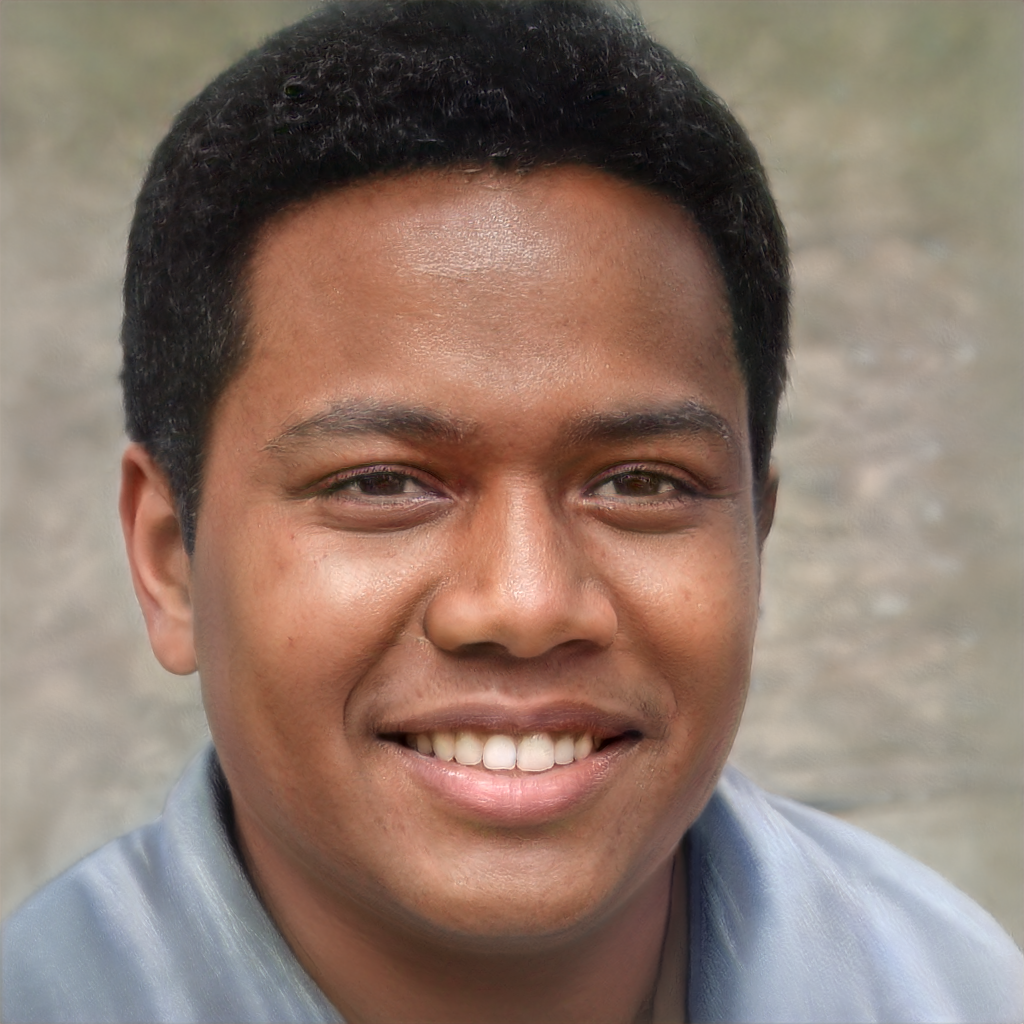

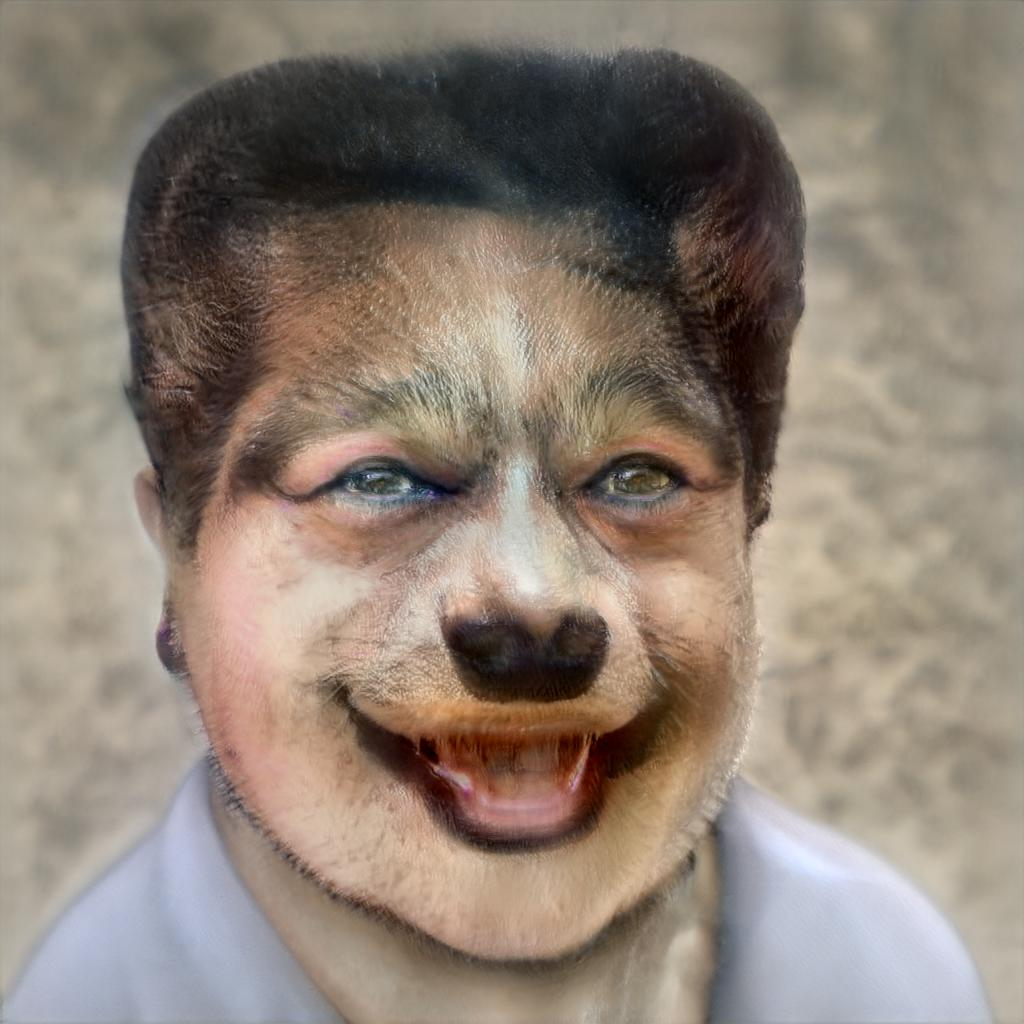

In [ ]:
#@markdown #Магия
#@markdown тут происходит обработка фотографии 

from PIL import Image

# найдем и вырежем лицо, это нужно для работы со стайлганом, который генерирует лица

!python align_images.py '/content/raw' '/content/aligned'

# теперь найдем лицо в пространстве стайлгана
!python project_images.py --num-steps 300 '/content/aligned' '/content/generated'

# для латентов сгенерируем картинки
import dnnlib
from stylegan2.dnnlib import tflib 
from pathlib import Path

latent_dir = Path('/content/generated')
latents = latent_dir.glob("*.npy")

for latent_file in latents:
    latent = np.load(latent_file)
    latent = np.expand_dims(latent,axis=0)
    latent = torch.from_numpy(latent).float().cuda()

    images = G.synthesis(latent) 

    res = to_pillow(images.detach().cpu().numpy()[0]).save(latent_file.parent / (f"{latent_file.stem}-toon.jpg"))

# посмотрим, что получилось

from IPython.display import Image 

embedded = Image(filename='/content/generated/input_01.png', width=256)
display(embedded)
tooned = Image(filename='/content/generated/input_01-toon.jpg', width=256)
display(tooned)